# Your first simulation

To follow this section,
you should create a new python file
with the following imports.

In [1]:
from pyqec.sparse import BinaryMatrix, BinaryVector
from pyqec.classical import LinearCode, BinarySymmetricChannel
from pyqec.experiments import ClassicalDecodingExperiment, Laboratory

I strongly suggest that you try to follow along and to run
the code snippets.

## The Hamming code

One of the simplest linear code is the Hamming code
defined from the parity check matrix

\begin{align*}
    H = 
    \begin{pmatrix}
        0 & 0 & 0 & 1 & 1 & 1 & 1 \\
        0 & 1 & 1 & 0 & 0 & 1 & 1 \\
        1 & 0 & 1 & 0 & 1 & 0 & 1 
    \end{pmatrix}.
\end{align*}

A simple way to remember this matrix is that 
each column is the binary representation of its position
when starting to count from 1 and not 0.

```{note}
The `pyqec` library is optimized to represent sparse linear codes.
These are linear codes with a parity check matrix with a relatively
small number of 1s.
The Hamming code is not a sparse code,
but since it is really small,
performances are not an issue.
```

To construct this matrix,
we specify the number of columns and
the **sorted** positions of the 1s in each row.

In [2]:
parity_check_matrix = BinaryMatrix(
    7,
    [
        [3, 4, 5, 6],
        [1, 2, 5, 6],
        [0, 2, 4, 6]
    ]
)

From this parity check matrix,
we can instantiate the corresponding linear code.

In [3]:
hamming_code = LinearCode(
    parity_check_matrix, 
    tag="Hamming code"
)

```{tip}
We gave the code a tag. 
This is useful to distinguish codes 
when we run many simulations with different codes.
```

We could also define a linear code from a generator matrix.

```python
some_code = LinearCode(generator_matrix=some_matrix)
```

We can even specify both matrices if they are orthogonal (\\( H\cdot G^T = 0 \\)).
If one matrix is omitted,
it will be computed from the other.
If neither a parity check matrix
nor a generator matrix is given,
an empty code is constructed.
This is not really useful for correcting errors,
but could be used as a place holder since it allocated
a minimal amount of memory.

## The decoder

An interesting property of the Hamming code 
is that for any binary vector the syndrome
tells us which bit to flip to map it to the closest codeword.

For example,
1110000 is a codeword of the Hamming code.
As expected,
it has a syndrome of 000.
If we flip the fifth bit we obtain the vector 1110100
with syndrome 101.
The number 101 is the binary representation of the number 5.
Thus, 
we know that we need to flip the fifth bit to recover the original codeword.
You can verify that this works if you start from a different codeword as well.
The codeword 1010101 for example.
We can use this trick to construct a decoder.

```{note}
This decoder can only correct a single error and will fail if
there are more errors. 
There are no decoder for the Hamming code that can correct
two errors.
```

To define a classical decoder to use with `pyqec`,
we need to define a class with the `decoder` method,
taking a binary vector usually called a message as single argument
and returning a codeword.

In [4]:
class HammingDecoder:
    def __init__(self, code):
        self.code = code

    def decode(self, message):
        syndrome = self.code.syndrome_of(message)
        bit = self.bit_to_flip(syndrome)
        if bit:
            # To flip the bit, we addition a vector with a single
            # 1 at the corresponding position.
            return message + BinaryVector(7, [bit])
        else:
            # It is already a codeword.
            return message

    def bit_to_flip(self, syndrome):
        bit_to_flip = 0
        for unsatisfied_position in syndrome:
            # The smallest position correspond 
            # to the highest power of 2.
            bit_to_flip += 2**(len(syndrome) - 1 - unsatisfied_position)
        if bit_to_flip > 0:
            # We offset because binary vector are 0-indexed.
            return bit_to_flip - 1 
        else:
            # There is no bit to flip
            return None

Let's analyze this.
In the `__init__` method,
we pass a code to initialize the decoder.
We could have hardcoded the Hamming code in the decoder,
but there exists an infinite amount of parity check matrices
that we could use with this decoder.
So we should keep this freedom.

Then, we should take a look at the `bit_to_flip` method.
This method is returning the position of the bit to flip
or `None` if there is no bit to flip.
It uses the `non_trival_positions` method of `BinaryVector`.
This method allows us to iterate over all positions where the syndrome is 1
in increasing order.

Finally,
the `decode` method starts by computing the syndrome 
before using the `bit_to_flip` method 
to find the correction.
If there is a bit to flip,
we create a new vector with a single one at the position
of the bit to flip
and we add it to the `message`.
However,
if there is no bit to flip,
we simply return the input.

From this point, it is easy to instantiate
the decoder.

In [5]:
decoder = HammingDecoder(hamming_code)

## Building the experiment

We would like to obtain a plot of the failure rate
as a function of the error probability using 
binary symmetric channels.

To create a binary symmetric channel,
we only need to specify the error probability.

In [6]:
noise = BinarySymmetricChannel(0.25)

```{note}
It is possible to specify a seed for the random
number generator as the second parameter.
```

The simplest way to simulate the performances of a classical decoder
is to use the `ClassicalDecodingExperiment` class.
A single simulation involve generating a random codeword,
then applying random noise on this codeword
and finally decoding it with the decoder.
We can estimate the failure rate 
by running many simulation and 
counting the number of time the decoder fails.
The `ClassicalDecodingExperiment` class take care
of all that.

In [7]:
experiment = ClassicalDecodingExperiment(hamming_code, decoder, noise)
result = experiment.run_n_times(1000)
print(result)

Statistics
----------
sample size: 1000
failure rate: 0.606
success rate: 0.394
uncertainty: 0.015451990163082553


Since we want to say the change in failure rate for different probabilities,
we should create a function to rapidly create a new experiment.

In [8]:
def build_experiment(probability):
    noise = BinarySymmetricChannel(probability)
    return ClassicalDecodingExperiment(hamming_code, decoder, noise)

## Running many experiments

One way to run many experiments is to use a bunch of for loops.
But, we aren't that barbaric.
Instead,
we are going to use the `Laboratory` class.
This allows us to group many experiments together before running them.
Of course,
if you have access to many CPUs,
you can run many experiments in parallel.
By now,
you should be eager to instantiate your first laboratory
and to add a few experiments to it.

In [9]:
laboratory = Laboratory(8) # There are 8 CPUs on my personal computer.

for probability in (0.05 * i for i in range(1, 21)):
    laboratory.add_experiment(build_experiment(probability))

It is almost as easy to obtain the results of all the experiments in the laboratory.

In [10]:
results = laboratory.run_all_experiments_n_times(1000)

## Visualization

As if laboratory where not cool enough already,
we can generate simple plots from the results they generate.
In the backend,
this is done with `matplotlib`,
but you don't even need to import it.

The most common plot is to have the failure rate as a function of the physical error rate
along with the uncertainties of course.
What if I tell you that you can do this plot with a single extra line of code?
Would you believe that?

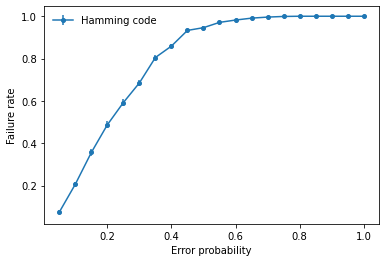

In [11]:
results.plot()

You worked hard to get this nice figure.
It would be great to save it.
To do so,
just specify the destination path as an argument to the `plot` method.

Also, 
have you noticed the legend in the figure?
This is the tag we specified earlier.
To each tag will corresponds one curve in the final plot.
You can use this if you want to compare the performances
of many codes.